# Densenet121 Pre trained to test

This jupyter notebook has the objective to, not only retrieve the accuracies of the Densenet121 pretrained, but to obtain also <br>
the layer features before the last classification layer.

In [66]:
 #Import necessary modules
import os
import torch

import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2
load_dotenv(override=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

### Set the path to here

Make sure the setup the paths properly!

In [69]:
#Path to assign tests (copy path directly)
notebooks_path = os.environ.get('NOTEBOOKS_PATH', None) or os.getcwd()

#Set the path to notebook working directory
os.chdir(notebooks_path)
print(os.getcwd())

import sys
#Append the path the src folder
sys.path.append(os.path.join(notebooks_path, "../src"))

/project/cs231/CS231N-Final-Proj/notebooks


### Import the necessary module for downloading

Note for this: EVERYTIME There is a change inside the download <br>
the changes inside the file would only be shown if the jupyter kernel is restarted. <br>


In [3]:
# Import the necessary modules
from utils import CXReader, DfReader_Inf

### Set the data path

In [4]:
# Create the data path
df_path = os.path.join(notebooks_path, os.pardir, "meta")

# If the environment is defined, prefer that over the local path
if "DATA_PATH" in os.environ:
    data_path = os.environ["DATA_PATH"]
data_path = data_path or os.path.join(df_path, "images")
print(f'df_path: {df_path}, \ndata_path: {data_path}')

df_path: /project/cs231/CS231N-Final-Proj/notebooks/../meta, 
data_path: /project/cs231/CS231N-Final-Proj/data/images/images


### Get the dataframes of the data
First, lets obtain the dataframes for the data and check that all metadata <br>
information has been set up properly. <br>

In [5]:
#Create a dataframe compiler
df_compiler = DfReader_Inf()

#set the path and retrieve the dataframes
df_compiler.set_folder_path(df_path)

#Get the dataframe holder and names
dfs_holder, dfs_names = df_compiler.get_dfs()

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 11.39it/s]

The file: train.csv has been retrieved
The file: test.csv has been retrieved
The file: val.csv has been retrieved


In [6]:
train_df = dfs_holder[dfs_names.index('train.csv')]
val_df = dfs_holder[dfs_names.index('val.csv')]
test_df = dfs_holder[dfs_names.index('test.csv')]

# Read the images and labels

Also, obtain DataLoaders for test, train, and validation datasets using <br>
the Dataloader class from pytorch.

In [7]:
print(torch.cuda.is_available())

True


In [8]:
# Get the device if cuda or not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Define a transformations for the VGGnet16 (requires a 224,224)
transform_training = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 256x256
    # transforms.CenterCrop((224, 224)),  # Center crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Define a transformations for the VGGnet16 (requires a 224,224)
transform_test_val = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 256x256
    # transforms.CenterCrop((224, 224)),  # Center crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


#Create datasets and dataloaders
train_dataset = CXReader(data_path=data_path, dataframe=dfs_holder[dfs_names.index('train.csv')], transform=transform_training,device=device)
test_dataset = CXReader(data_path=data_path, dataframe=dfs_holder[dfs_names.index('test.csv')], transform=transform_test_val, device=device)
val_dataset = CXReader(data_path=data_path, dataframe=dfs_holder[dfs_names.index('val.csv')], transform=transform_test_val, device=device)

#Sampled images from train to see single shape
sample_image, sample_label = train_dataset[1]
print("====Dataset Information====")
print("Total training samples", len(train_dataset))
print("Total training samples", len(test_dataset))
print("Total training samples", len(val_dataset))
print("====Dataset Information====\n\n")
print("====Sample Data====")
print(f"Image: {sample_image.shape}, labels: {sample_label.shape}")
print("====Sample Data====\n\n")

# With batch size of 32, and shuffle true, and num workers = 4
batch_size = 32

# Set the number of workers on local machine to be 0 for debugging
if os.environ.get("NUM_WORKERS"):
    num_workers = int(os.environ.get("NUM_WORKERS"))
else:
    # currently we are on a dual core machine
    # ToDo: change this to auto detect number of core
    num_workers = 2

# Create a sampler to handle class imbalance
class_counts = train_df.Infiltration.value_counts()
class_weights = 1. / class_counts
samples_weights = torch.Tensor(class_weights[train_df.Infiltration].to_list())
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, sampler=sampler)



# lets have shuffle false in validation set so that we can iterate through a small number of 
# samples and calculate the ROC accuracy
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#Iterate inside a batch
for idx, batch in enumerate(train_loader):
    print(f"batch number: {idx}")
    images, labels = batch
    print("Shape of batch of images and labels")
    print(f"Images: {images.shape}, labels: {labels.shape}")
    if idx == 5:
        print("It can iterate through all batches")
        break

====Dataset Information====
Total training samples 78506
Total training samples 21081
Total training samples 12533
====Dataset Information====


====Sample Data====
Image: torch.Size([3, 224, 224]), labels: torch.Size([1])
====Sample Data====


batch number: 0
Shape of batch of images and labels
Images: torch.Size([32, 3, 224, 224]), labels: torch.Size([32, 1])
batch number: 1
Shape of batch of images and labels
Images: torch.Size([32, 3, 224, 224]), labels: torch.Size([32, 1])
batch number: 2
Shape of batch of images and labels
Images: torch.Size([32, 3, 224, 224]), labels: torch.Size([32, 1])
batch number: 3
Shape of batch of images and labels
Images: torch.Size([32, 3, 224, 224]), labels: torch.Size([32, 1])
batch number: 4
Shape of batch of images and labels
Images: torch.Size([32, 3, 224, 224]), labels: torch.Size([32, 1])
batch number: 5
Shape of batch of images and labels
Images: torch.Size([32, 3, 224, 224]), labels: torch.Size([32, 1])
It can iterate through all batches


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


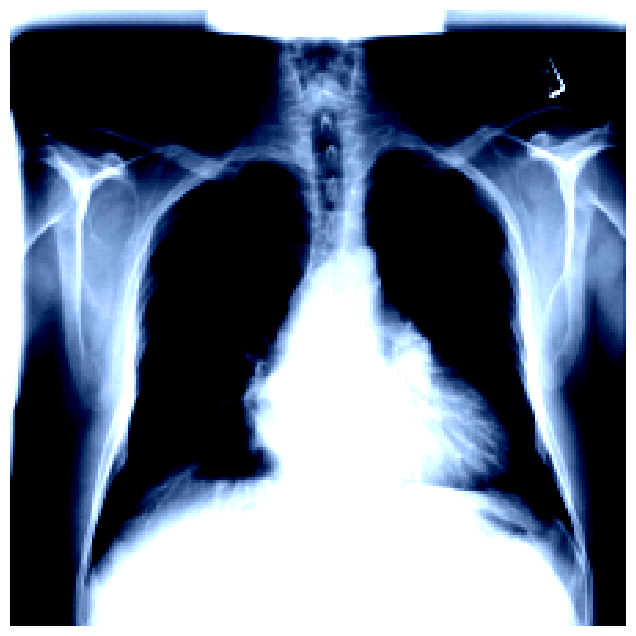

torch.Size([3, 224, 224])


In [9]:
from utils.plot import plot_image_no_normalisation

plot_image_no_normalisation(sample_image)
print(sample_image.shape)

### Load the densenet121 pretrained model

Check if you have GPU Envidia! Else, use the cpu

In [10]:
#Load the pretrained model
densenet121 = models.densenet121(weights='DEFAULT')

In [11]:
print(densenet121.classifier)
print([x.shape for x in densenet121.classifier.parameters()])

Linear(in_features=1024, out_features=1000, bias=True)
[torch.Size([1000, 1024]), torch.Size([1000])]


In [12]:
# NEW CODE CELL to conduct fine-tuning on Vggnet16 only on the last (Linear) layer

# First, freeze all the parameters
for param in densenet121.parameters():
    param.requires_grad = False

In [13]:
# Modify the last layer for the last 20 classes
num_classes = sample_label.shape[0]  # Number of classes for your specific task
num_features = densenet121.classifier.in_features #Get all of the features after convolutional layers

print(num_classes)
print(num_features)

1
1024


In [14]:
# Obtain the same classifier you got befor with lower number of classes, so we can pretrain it
# Since we are using BCEWithLogitsLoss, lets not have Sigmoid at the end
dropout_p = 0.1
densenet121.classifier = nn.Sequential(
    nn.Linear(num_features, num_classes, bias=True)
)

print(densenet121.classifier)

Sequential(
  (0): Linear(in_features=1024, out_features=1, bias=True)
)


In [15]:
# Create state_dict path
model_dict_path = os.path.join(notebooks_path, os.pardir, "models")

if os.path.exists(model_dict_path) == False:
    os.mkdir(model_dict_path)
print(model_dict_path)

/project/cs231/CS231N-Final-Proj/notebooks/../models


In [41]:
class_counts

Infiltration
0    65767
1    12739
Name: count, dtype: int64

In [71]:
# Loss Function
# Create the weights for the loss function
# The weights are the inverse of the class frequency
# This is to account for the class imbalance
# Lets get the frequencies of the classes in the training set

# w+ is N / (N + P). It should be the same as the ratio of negative to positive samples
pos_weight = torch.tensor(class_counts[0] / class_counts[1])
print(pos_weight)

criterion = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight)

tensor(5.1627, dtype=torch.float64)


In [54]:
# Optimiser
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = densenet121

# we are updating the below parameters
for i, layer in enumerate(model.classifier.children()):
    print(f"Layer {i}: {layer.__class__.__name__}")
    for name, param in layer.named_parameters():
        print(f"  {name}: {param.size()}")

optimizer = Adam(model.classifier.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)


Layer 0: Linear
  weight: torch.Size([1, 1024])
  bias: torch.Size([1])


In [55]:
use_wandb = os.environ.get('USE_WANDB', False) == 'True'
if use_wandb:
    import wandb

In [56]:
threshold = 0.5
def exact_match_accuracy(y_pred, y_true):
    y_pred = (y_pred > threshold).float()
    
    # Compute the number of exactly correct predictions
    exact_match = (y_true == y_pred).all(dim=1).float()
    
    # Calculate accuracy as mean of exact matches
    accuracy = exact_match.mean()
    
    return accuracy.item()


def hamming_loss(y_pred, y_true):
    """
    Compute the Hamming loss between true and predicted labels.

    Args:
    y_true (torch.Tensor): Tensor containing true binary labels (0 or 1).
    y_pred (torch.Tensor): Tensor containing predicted scores (probabilities or logits).

    Returns:
    float: Hamming loss.
    """
    # Apply threshold to convert probabilities to binary predictions
    y_pred = (y_pred > threshold).float()
    
    # Calculate Hamming loss as the fraction of incorrect labels
    loss = torch.mean((y_true != y_pred).float())
    return loss.item()


In [57]:
def compute_auc(labels, predictions):
    """Computes Area Under the Curve (AUC) from prediction scores.

    Returns:
        AUROC score for the class
    """
    gt_np = labels.numpy()
    pred_np = predictions.numpy()
    return roc_auc_score(gt_np, pred_np, average='macro')

In [58]:
# # Example usage
# y_true = torch.tensor([[0, 1, 0, 1], [1, 0, 1, 0]])
# y_pred_probs = torch.tensor([[0.2, 0.8, 0.1, 0.9], [0.9, 0.3, 0.2, 0.1]])

# accuracy = exact_match_accuracy(y_pred_probs, y_true)
# print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# # Example usage
# y_true = torch.tensor([[0, 1, 0, 1], [1, 0, 1, 0]], dtype=torch.float32)
# y_pred_probs = torch.tensor([[0.2, 0.8, 0.3, 0.9], [0.9, 0.8, 0.3, 0.2]], dtype=torch.float32)

# loss = hamming_loss(y_pred_probs, y_true)
# print(f"Hamming Loss: {loss:.4f}")

In [59]:
VAL_BATCHES = 30

def val_accuracy(loader, model):
    # ToDo: add train flag in the dataset
    # if loader.dataset.train:
    #     print('Checking accuracy on validation set')
    # else:
    #     print('Checking accuracy on test set')
    model.eval()  # set model to evaluation mode
    ground_truth = torch.FloatTensor()
    predictions = torch.FloatTensor()
    with torch.no_grad():
        for t, (images, labels) in enumerate(loader):
            images = images.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            labels = labels.to(device=device, dtype=torch.float32)
            logits = model(images)

            probabilities = torch.sigmoid(logits)

            predictions = torch.cat((predictions, probabilities.cpu()), 0)
            ground_truth = torch.cat((ground_truth, labels.cpu()), 0)

            # run only for VAL_BATCHES batches to speed up the training
            if t == VAL_BATCHES:
                break
        roc_score = compute_auc(ground_truth, predictions)

        print('Accuracy %f with %d images' % (roc_score, (t + 1) * loader.batch_size))

In [ ]:
for i in range(5):
    for t, (images, labels) in enumerate(train_loader):
        positive = labels.sum()
        negative = labels.size(0) - positive
        print(f"Positive: {positive}, Negative: {negative}")

In [60]:
def finetune_model(model, data_loader, num_epochs, device:str):
    # Initialize wandb
    if use_wandb:
        wandb.init(
            project="cs231-project", 
            name="densenet121-finetune-adam-gpu",
            config={
                "optimizer": "Adam",
                "lr": 0.001,
                "batch_size": 16,
                "num_classes": 14,
                "dropout_p": 0.1
            }
        )

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-------------')
            
        for t, (images, labels) in enumerate(data_loader):

            # Convert labels to float type (also need to move to CUDA again!)
            labels = labels.to(device, dtype=torch.float32)
            images = images.to(device, dtype=torch.float32)

            model = densenet121.to(device)
            model.train()
            
            # forward pass - getting probabilities since applied sigmoid in the last layer
            logits = model(images)

            # compute loss. Criterian is BCEWithLogitsLoss so no need to apply sigmoid
            loss = criterion(logits, labels)

            # zero out gradients
            optimizer.zero_grad()
        
            
            probabilities = torch.sigmoid(logits)
            pred_labels = (probabilities > threshold).float()

            # Calculate TP, FP, TN, FN and accuracy
            TP = torch.sum((pred_labels == 1) & (labels == 1)).item()
            FP = torch.sum((pred_labels == 1) & (labels == 0)).item()
            TN = torch.sum((pred_labels == 0) & (labels == 0)).item()
            FN = torch.sum((pred_labels == 0) & (labels == 1)).item()
            train_accuracy = ((TP + TN) / (TP + FP + TN + FN)) * 100.0

            loss.backward()
            optimizer.step()

            # ToDo: Once figure out a way to get the validation score, also step the scheduler

            if use_wandb:
                wandb.log({"train_loss": loss.item()})

            if t % 2 == 0:
                print('Epoch: {}, Iteration {}, Loss: {}, Train Accuracy: {}'.format(epoch + 1, t, loss.item(), train_accuracy))

            if t % 50 == 0:
                val_accuracy(val_loader, model)
                
        
        # Save parameters for each epoch
        torch.save(model.state_dict(), os.path.join(model_dict_path, "densenet121_finetune_params.pth"))

In [61]:
# Let's do fine-tuning
finetune_model(model=model, data_loader=train_loader, num_epochs=5, device=device)

Epoch 1/5
-------------


Epoch: 1, Iteration 0, Loss: 25.766796112060547, Train Accuracy: 34.375
Accuracy 0.627051 with 992 images
Epoch: 1, Iteration 2, Loss: 20.504188537597656, Train Accuracy: 56.25
Epoch: 1, Iteration 4, Loss: 18.713062286376953, Train Accuracy: 65.625
Epoch: 1, Iteration 6, Loss: 21.08946990966797, Train Accuracy: 59.375
Epoch: 1, Iteration 8, Loss: 21.92860221862793, Train Accuracy: 50.0
Epoch: 1, Iteration 10, Loss: 20.738262176513672, Train Accuracy: 56.25
Epoch: 1, Iteration 12, Loss: 22.208057403564453, Train Accuracy: 56.25
Epoch: 1, Iteration 14, Loss: 18.03763771057129, Train Accuracy: 78.125
Epoch: 1, Iteration 16, Loss: 18.281173706054688, Train Accuracy: 71.875
Epoch: 1, Iteration 18, Loss: 20.721940994262695, Train Accuracy: 56.25
Epoch: 1, Iteration 20, Loss: 19.36827850341797, Train Accuracy: 62.5
Epoch: 1, Iteration 22, Loss: 19.618446350097656, Train Accuracy: 59.375
Epoch: 1, Iteration 24, Loss: 19.646928787231445, Train Accuracy: 46.875
Epoch: 1, Iteration 26, Loss: 19.4

KeyboardInterrupt: 

In [ ]:
densenet121.load_state_dict(torch.load(os.path.join(model_dict_path, "vgg16_finetune_params.pth")))

<All keys matched successfully>

### Create a function that would evaluate the model.

Make sure it outputs all of the accuracies of all 20 conditions. <br>

In [ ]:
import torch.nn.functional as F

def evaluate_model(model, data_loader, limit:int, device:str):
    """
    Instance method that would evaluate with a given
    data loader, the accuracies obtained by the VGGNET16
    """
    model.eval()
    threshold = 0.5
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    #Use no grad to not perform backpropagation for inference time
    with torch.no_grad():
        #Iterate through each of the images and labels
        
        # Calculate the total numbers for metrics
        TP, FP, TN, FN = 0.0, 0.0, 0.0, 0.0
        for idx, batch in enumerate(data_loader):
    
            #See if it works
            images_inputs, images_labels = batch
            images_inputs, images_labels = images_inputs.to(device), images_labels.to(device)

            #Print the shape of each one of them
            print(f"Inputs shape: {images_inputs.shape}, Labels shape: {labels.shape}")

            #Send the outputs to model in device
            outputs = model(images_inputs)

            #Binarize the output with threshold
            pred_labels = (outputs > threshold).float()

            # Calculate batch-wise TP, FP, TN, FN
            b_TP = torch.sum((pred_labels == 1) & (images_labels == 1)).item()
            b_FP = torch.sum((pred_labels == 1) & (images_labels == 0)).item()
            b_TN = torch.sum((pred_labels == 0) & (images_labels == 0)).item()
            b_FN = torch.sum((pred_labels == 0) & (images_labels == 1)).item()
            TP += b_TP
            FP += b_FP
            TN += b_TN
            FN += b_FN

        #_, predicted = torch.max(outputs, 1)  # Get the index of the maximum log-probability
        accuracy = ((TP + TN) / (TP + FP + TN + FN)) * 100.0
        precision = (TP / (TP + FP)) * 100.0 if (TP + FP) > 0 else 0.0
        recall = (TP / (TP + FN)) * 100.0 if (TP + FN) > 0 else 0.0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        print("Accuracy: {:.2f}%".format(accuracy))
        print("Precision: {:.2f}%".format(precision))
        print("Recall: {:.2f}%".format(recall))
        print("F1 Score: {:.2f}%".format(f1_score))

            # accuracies.append(accuracy)
            # precisions.append(precision)
            # recalls.append(recall)
            # f1_scores.append(f1_score)

            # if idx == limit:
            #     print("Limit reached")
            #     break
    return accuracies, precisions, recalls, f1_scores

In [ ]:
# Evaluate on the eval set
accuracies, precisions, recalls, f1_scores = evaluate_model(model, test_loader, 5, device=device)

Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32, 20])
Inputs shape: torch.Size([32, 3, 224, 22